In [3]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2 = (0.1, 0.05, 0.6, 0.1, 0.2, 0.1, 0.1, 7.05, 2.0, 0.4)

initial_values = (0.248, 0.0973, 0.0027)

In [5]:
class CellApoptosisSystem:
    def __init__(self, initial_X, k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2):
        self.initial_X, self.k0, self.kd, self.k1, self.j1, self.km1, self.jm1, self.j2, self.km3, self.jm3, self.k2 = initial_X,k0,kd,k1,j1,km1,jm1,j2,km3,jm3,k2

    def model(X, _, k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2):
        x, y, z = X
        v0 = k0
        v1 = k1 * z * (j1 + y)
        vm1 = km1 * y / (jm1 + y)
        v2 = k2 * y * x / (j2 + x)
        vm3 = km3 * x * y / (jm3 + y)

        dxdt = v0 - v2 -kd * x
        dydt = v1 - vm1 - vm3
        dzdt = -dydt

        return np.array([dxdt, dydt, dzdt])

    def solve(self, t):
        res = odeint(CellApoptosisSystem.model, self.initial_X, t, args=(self.k0, self.kd, self.k1, self.j1, self.km1, self.jm1, self.j2, self.km3, self.jm3, self.k2))
        return res


In [6]:
CA = CellApoptosisSystem(initial_values, k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2)

In [7]:
t_phys_int = [0,400]
Np_phys = 10**4
t_phys = torch.linspace(t_phys_int[0], t_phys_int[1], Np_phys)

sol_phys = CA.solve(t=t_phys)
x_phys, y_phys, z_phys = sol_phys.T
t_phys = t_phys.requires_grad_(True)

In [8]:
eps = 0

def get_noisy_measurements(n, xi, yi, zi, t, eps):
    bar_x = np.mean(xi)
    print(f"mean of x: ", bar_x)
    bar_y = np.mean(yi)
    print(f"mean of y: ", bar_y)
    bar_z = np.mean(zi)
    print(f"mean of z: ", bar_z)

    assert n <= len(t)

    step = len(t)//n

    indices = np.arange(0, len(t), step)[:n]

    x = xi[indices]
    y = yi[indices]
    z = zi[indices]
    x = x + eps * bar_x * np.random.normal(loc=0.0, scale=1.0, size=len(x))
    y = y + eps * bar_y * np.random.normal(loc=0.0, scale=1.0, size=len(y))
    z = z + eps * bar_z * np.random.normal(loc=0.0, scale=1.0, size=len(z))

    return torch.vstack([torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(z, dtype=torch.float32)]), t[indices].clone().detach()

In [9]:
measurements, measurements_t = get_noisy_measurements(30, x_phys, y_phys, z_phys, t_phys, eps)

mean of x:  1.9066431620177107
mean of y:  0.000813719514197604
mean of z:  0.09918628048580237


Text(0.5, 1.0, 'Test ')

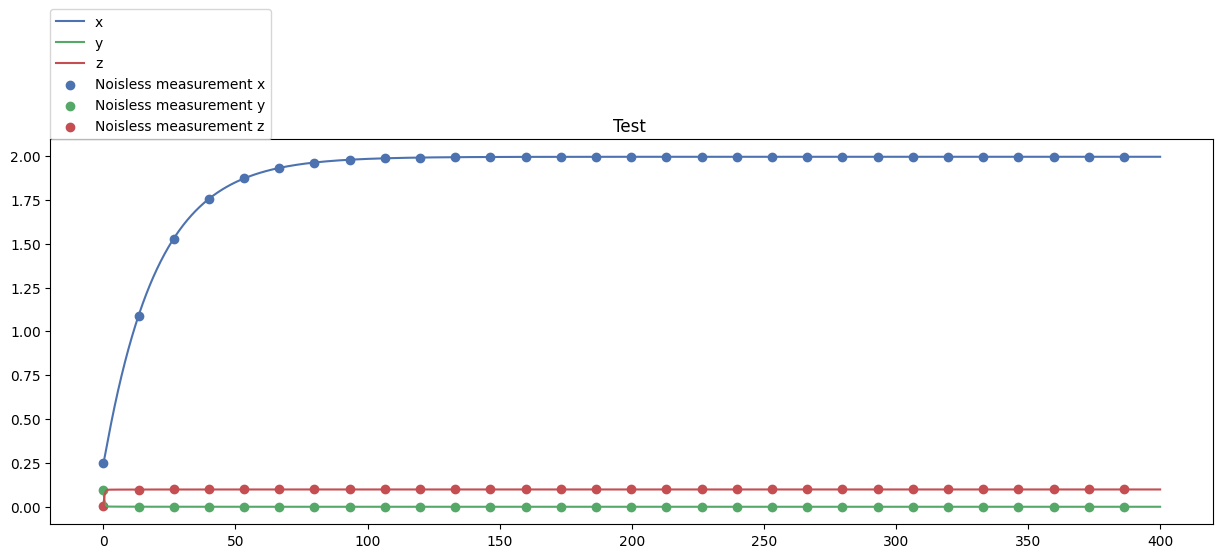

In [10]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_phys.detach().numpy(), x_phys, label='x')
ax.plot(t_phys.detach().numpy(), y_phys, label='y')
ax.plot(t_phys.detach().numpy(), z_phys, label='z')
ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisless measurement x')
ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisless measurement y')
ax.scatter(measurements_t.detach().numpy(), measurements[2,:], label='Noisless measurement z')
ax.legend(loc=(0,1))
ax.set_title('Test ')

In [11]:
"""
Lotka-Volterra and Apoptosis model:
    one input for t followed by a scaling layer; 2
    hidden layers of 64 units for the surrogate
    solution; 2 hidden layers of 16 units for the hidden
    component approximation; sigmoid activation
"""

class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias


class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()

        self.layers = nn.ModuleList()
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
u = U(1,3, [64,64])
u = u.to(device)

f = F(3,2, [16,16])
f = f.to(device)

[48000/50001] Overall:0.00036413242924027145, Physics loss: 1.3408522136160173e-05, Datapoint loss: 2.2968786652199924e-05, Boundary loss: 3.593509489974167e-08


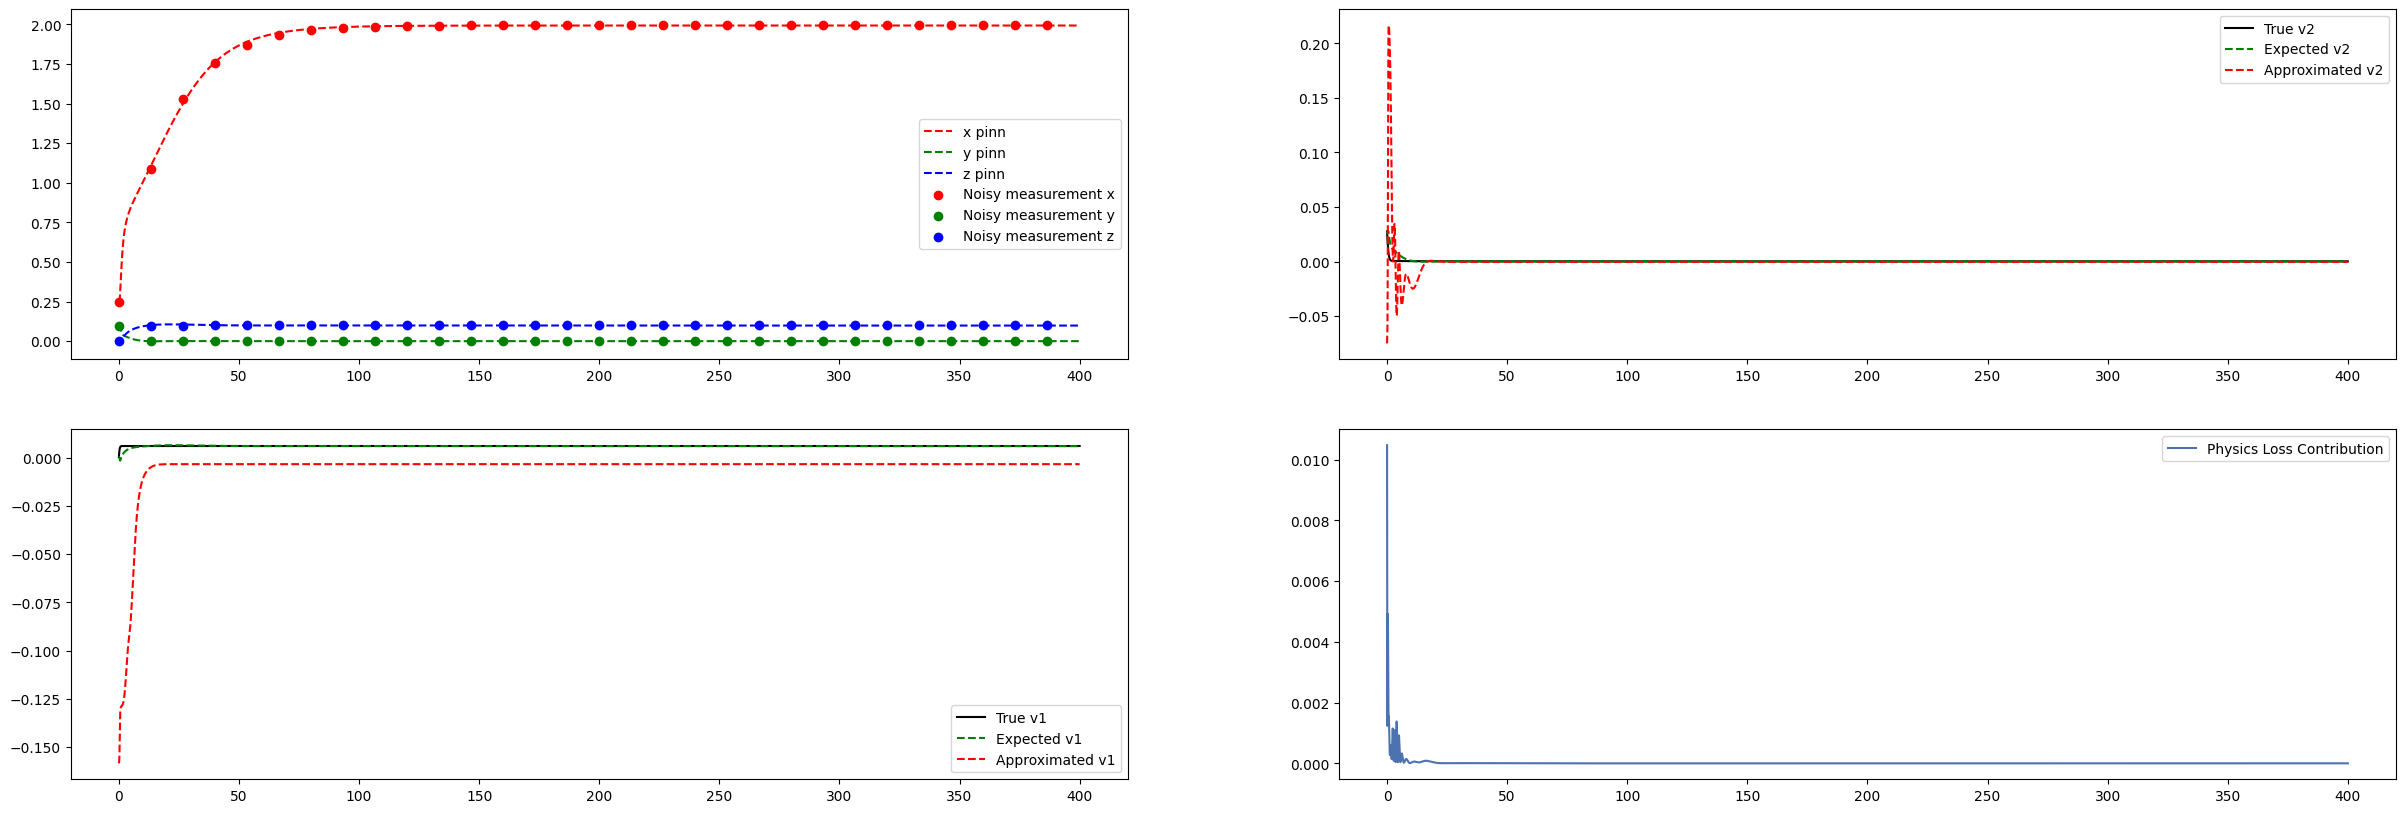

In [21]:
# Train
lr1 = 1e-2
lr2 = 3e-2
params_to_optimize = [
    {'params': u.parameters(), 'lr': lr1},  # lr1 is the learning rate for net1
    {'params': f.parameters(), 'lr': lr2}   # lr2 is the learning rate for net2
]
# optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr)
optimizer = torch.optim.Adam(params_to_optimize)
lambda1, lambda2, lambda3 = 1e1, 1e1, 1e1 # Boundary loss, Physics loss, Datapoint loss

cumulative_physics_loss = torch.zeros_like(t_phys).cpu()
update_count = torch.zeros_like(t_phys).cpu()

total_itr = 50001
for i in range(total_itr):
    optimizer.zero_grad()

    # Boundary loss -------
    x0, y0, z0 = CA.initial_X
    t_boundary = 0
    u_b = u(torch.Tensor([[t_boundary]]).to(device))

    # f_b = u(torch.Tensor([[t_boundary]]).to(device))

    loss1 = nn.MSELoss()(u_b, torch.Tensor([[x0,y0,z0]]).to(device)) # ensure the initial conditions


    # Physics loss -------

    phys_input = t_phys.to(device).reshape(-1,1) # Collocation points
    u_p = u(phys_input) # Output of network at collocation points
    x, y, z = u_p[:,0].reshape(-1,1), u_p[:,1].reshape(-1,1), u_p[:,2].reshape(-1,1) # Estimated values of x, y and z
    dxdt = torch.autograd.grad(x, phys_input, torch.ones_like(x), create_graph=True)[0]
    dydt = torch.autograd.grad(y, phys_input, torch.ones_like(y), create_graph=True)[0]
    dzdt = torch.autograd.grad(z, phys_input, torch.ones_like(z), create_graph=True)[0]


    f_p = f(u_p.to(device)) # need to detach?
    f_a, f_b = f_p[:,0].reshape(-1,1), f_p[:,1].reshape(-1,1)

    v0 = CA.k0
    v1 = CA.k1 * z * (CA.j1 + y)
    vm1 = CA.km1 * y / (CA.jm1 + y)
    v2 = CA.k2 * y * x / (CA.j2 + x)
    vm3 = CA.km3 * x * y / (CA.jm3 + y)

    dudt = torch.hstack([dxdt - v0 + f_a + CA.kd * x,
                         dydt - f_b + vm1 + vm3,
                         dzdt + dydt])

    lossx = nn.MSELoss()(dudt[:,0], torch.zeros_like(dudt[:,0]))
    lossy = nn.MSELoss()(dudt[:,1], torch.zeros_like(dudt[:,1]))
    lossz = nn.MSELoss()(dudt[:,2], torch.zeros_like(dudt[:,2]))

    loss2 = lossx + lossy + lossz / 3

    with torch.no_grad():
        individual_losses = (dudt[:,0]**2 + dudt[:,1]**2 + dudt[:,2]**2).detach().cpu()
        cumulative_physics_loss += individual_losses
        update_count += 1

    # Datapoint loss -------
    u_n = u(measurements_t.to(device).reshape(-1,1))
    loss3 = nn.MSELoss()(u_n, measurements.to(device).T)

    # Backwards -------
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3

    loss.backward()
    optimizer.step()

    if i% 4000 == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(2,2, figsize=(30,10))

            # pinn

            u_p = u(t_phys.to(device).reshape(-1,1))
            x, y, z = u_p[:,0], u_p[:,1], u_p[:,2]
            ax[0,0].plot(t_phys.detach().cpu().numpy(), x.cpu(), label='x pinn', linestyle='--', color='red')
            ax[0,0].plot(t_phys.detach().cpu().numpy(), y.cpu(), label='y pinn', linestyle='--', color='green')
            ax[0,0].plot(t_phys.detach().cpu().numpy(), z.cpu(), label='z pinn', linestyle='--', color='blue')
            ax[0,0].scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x', color='red')
            ax[0,0].scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y', color='green')
            ax[0,0].scatter(measurements_t.detach().numpy(), measurements[2,:], label='Noisy measurement z', color='blue')
            ax[0,0].legend()

            true_v1 = CA.k1 * z_phys * (CA.j1 + y_phys)
            true_v2 = CA.k2 * y_phys * x_phys / (CA.j2 + x_phys)
            ax[0,1].plot(t_phys.detach().cpu().numpy(), true_v2, label='True v2', color='black')
            ax[0,1].plot(t_phys.detach().cpu().numpy(), v2.detach().cpu().numpy(), label='Expected v2', linestyle='--', color='green')

            f_p = f(u_p.to(device))
            f_a, f_b = f_p[:,0], f_p[:,1]
            # Careful here. The network F is trained on the physics loss, which brings the unknown terms on one side of the equality.
            # This means that F is learning the negative values. Keep it in mind if the loss changes (e.g you bring the diff. operators on the other
            # side rather than the unknowns)
            ax[0,1].plot(t_phys.detach().cpu().numpy(), -f_a.cpu(), label='Approximated v2', linestyle='--', color='red')
            ax[0,1].legend()

            # true_dxdt = CA.k0 - CA.k2 * y_phys * x_phys / (CA.j2 + x_phys) - CA.kd * x_phys
            # true_dydt = CA.k1 * z_phys * (CA.j1 + y_phys) - CA.k2 * y_phys * x_phys / (CA.j2 + x_phys) - CA.km3 * x_phys * y_phys / (CA.jm3 + y_phys)
            # true_dzdt = -true_dydt
            # ax[1,0].plot(t_phys.detach().cpu().numpy(), true_dxdt, label='true dxdt', color='red')
            # ax[1,0].plot(t_phys.detach().cpu().numpy(), true_dydt, label='true dydt', color='green')
            # ax[1,0].plot(t_phys.detach().cpu().numpy(), true_dzdt, label='true dzdt', color='blue')

            # est_dxdt = dxdt.cpu()
            # est_dydt = dydt.cpu()
            # est_dzdt = dzdt.cpu()
            # ax[1,0].plot(t_phys.detach().cpu().numpy(), est_dxdt, label='dxdt', linestyle='--', color='red')
            # ax[1,0].plot(t_phys.detach().cpu().numpy(), est_dydt, label='dydt', linestyle='--', color='green')
            # ax[1,0].plot(t_phys.detach().cpu().numpy(), est_dzdt, label='dzdt', linestyle='--', color='blue')

            ax[1,0].plot(t_phys.detach().cpu().numpy(), true_v1, label='True v1', color='black')
            ax[1,0].plot(t_phys.detach().cpu().numpy(), v1.detach().cpu().numpy(), label='Expected v1', linestyle='--', color='green')
            ax[1,0].plot(t_phys.detach().cpu().numpy(), -f_b.cpu(), label='Approximated v1', linestyle='--', color='red')
            ax[1,0].legend()

            average_physics_loss = cumulative_physics_loss / update_count
            ax[1,1].plot(t_phys.detach().cpu().numpy(), individual_losses.cpu(), label='Physics Loss Contribution')
            # ax[1,1].plot(t_phys.detach().cpu().numpy(), average_physics_loss.cpu(), label='Average Physics Loss Contribution')
            ax[1,1].legend()

            clear_output(wait=True)
            print(f'[{i}/{total_itr}] Overall:{loss.item()}, Physics loss: {loss2.item()}, Datapoint loss: {loss3.item()}, Boundary loss: {loss1.item()}')
            plt.show()

In [22]:
with torch.no_grad():

    est_unk_a = -f_a.cpu().reshape(-1)
    #print(est_unk_a)
    est_unk_b = f_b.cpu().reshape(-1)
    #print(est_unk_b)
    true_unk_a = torch.Tensor(CA.k2 * y_phys * x_phys / (CA.j2 + x_phys))
    #print(true_unk_a)
    true_unk_b = torch.Tensor(CA.k1 * z_phys * (CA.j1 + y_phys))
    #print(true_unk_b)

    mse_a = torch.mean((true_unk_a - est_unk_a)**2)
    mse_b = torch.mean((true_unk_b - est_unk_b)**2)
    print((mse_a.item()+mse_b.item())/2)

0.00012694585529970936


In [23]:
with torch.no_grad():

    est_x = x.cpu().reshape(-1)
    est_y = y.cpu().reshape(-1)
    est_z = z.cpu().reshape(-1)

    true_x = torch.Tensor(x_phys)
    true_y = torch.Tensor(y_phys)
    true_z = torch.Tensor(z_phys)

    mse_x = torch.mean((true_x - est_x)**2)
    mse_y = torch.mean((true_y - est_y)**2)
    mse_z = torch.mean((true_z - est_z)**2)
    print((mse_x.item()+mse_y.item()+mse_z.item())/3)

0.00024889730866561877
